In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from concurrent.futures import ProcessPoolExecutor, as_completed

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 500)

In [2]:
train_df = pd.read_parquet('../data/feature_engineering_v10_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v10_test_df.parquet')

train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

train_log = pd.read_csv('../train_log.csv')
test_log = pd.read_csv('../test_log.csv')

In [3]:
train_df

session_id  yado_no  target  predict_no  \
0        000125c737df1802b6e365f93c96d3c8     7531       0           0   
1        000125c737df1802b6e365f93c96d3c8      441       0           1   
2        000125c737df1802b6e365f93c96d3c8     2480       0           2   
3        000125c737df1802b6e365f93c96d3c8    13240       0           3   
4        000125c737df1802b6e365f93c96d3c8    10378       1           4   
...                                   ...      ...     ...         ...   
2777522  fffe8a472ae6a96c9da05a30ac3ed6c5     4772       0           5   
2777523  fffe8a472ae6a96c9da05a30ac3ed6c5     1482       0           6   
2777524  fffe8a472ae6a96c9da05a30ac3ed6c5     4116       0           7   
2777525  fffe8a472ae6a96c9da05a30ac3ed6c5    10613       0           8   
2777526  fffe8a472ae6a96c9da05a30ac3ed6c5     4526       0           9   

         seq_no  seen_yad  max_seq_no  diff_seq_no  is_odd  \
0            -1         0           0           -1      -1   
1            -1         0           0           -1      -1   
2            -1         0           0           -1      -1   
3            -1         0           0           -1      -1   
4            -1         0           0           -1      -1   
...         ...       ...         ...          ...     ...   
2777522      -1         0           2           -1      -1   
2777523      -1         0           2           -1      -1   
2777524      -1         0           2           -1      -1   
2777525      -1         0           2           -1      -1   
2777526      -1         0           2           -1      -1   

         multiple_visits_flag  yad_type  total_room_cnt  wireless_lan_flg  \
0                           0         0            97.0               1.0   
1                           0         0           314.0               1.0   
2                           0         0           144.0               1.0   
3                           0         0           150.0               1.0   
4                           0         0           264.0               1.0   
...                       ...       ...             ...               ...   
2777522                     0         1            -1.0               1.0   
2777523                     0         0           198.0               1.0   
2777524                     0         0            94.0               1.0   
2777525                     0         0           310.0               1.0   
2777526                     0         0           100.0               1.0   

         onsen_flg  kd_stn_5min  kd_bch_5min  kd_slp_5min  kd_conv_walk_5min  \
0                0         -1.0         -1.0         -1.0                1.0   
1                0         -1.0         -1.0         -1.0                1.0   
2                0          1.0         -1.0         -1.0                1.0   
3                1          1.0         -1.0         -1.0                1.0   
4                1         -1.0         -1.0         -1.0                1.0   
...            ...          ...          ...          ...                ...   
2777522          0         -1.0         -1.0         -1.0               -1.0   
2777523          0         -1.0         -1.0         -1.0               -1.0   
2777524          1         -1.0         -1.0         -1.0               -1.0   
2777525          0         -1.0         -1.0         -1.0               -1.0   
2777526          0         -1.0         -1.0         -1.0                1.0   

                                   wid_cd                            ken_cd  \
0        43875109d1dab93592812c50d18270a7  3b09a7ce9934c00fd266f9cf246308d1   
1        43875109d1dab93592812c50d18270a7  3b09a7ce9934c00fd266f9cf246308d1   
2        43875109d1dab93592812c50d18270a7  3b09a7ce9934c00fd266f9cf246308d1   
3        43875109d1dab93592812c50d18270a7  3b09a7ce9934c00fd266f9cf246308d1   
4        43875109d1dab93592812c50d18270a7  3b09a7ce9934c00fd266f9cf246308d1   
...                                  

In [4]:
print(train_df['seen_yad'].value_counts())
print(test_df['seen_yad'].value_counts())

0    2777527
Name: seen_yad, dtype: int64
0    1683604
Name: seen_yad, dtype: int64


In [ ]:
# ver1では一旦無視
# Ranking学習の場合、Taregetの数字を変える
# 1を1に、0を2に変える
# train_label['target'] = train_label['target'].replace(0, 2)

### LightGBM Ranker（candidate用のRankerモデル）

In [5]:
import xgboost as xgb
from sklearn.metrics import label_ranking_average_precision_score

# 特徴量とターゲットの定義
features = [x for x in train_df.columns if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad')]
target = 'target'

# XGBoost のパラメータ（GPU使用）
params = {
    'objective': 'rank:pairwise',  # ランキングタスク用の目的関数
    'eval_metric': 'map',  # MAPを評価指標とする
    'learning_rate': 0.05,
    'n_estimators': 30000,
    'max_depth': 6,
    'seed': 42531,
    'tree_method': 'gpu_hist'  # GPUを使用するための設定
}

In [7]:
map_scores = []
test_pred = []
oof_pred = np.zeros(len(train_df))

for fold in range(10):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # XGBoostデータセットを作成
    dtrain = xgb.DMatrix(train_data[features], label=train_data[target])
    dvalid = xgb.DMatrix(valid_data[features], label=valid_data[target])

    # モデルの訓練
    model = xgb.train(params, dtrain, num_boost_round=30000, evals=[(dvalid, 'eval')], early_stopping_rounds=100, verbose_eval=1)

    # バリデーションデータでの予測と評価
    valid_pred = model.predict(dvalid)
    oof_pred[valid_data.index] = valid_pred
    
    # MAPスコアの計算
    map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
    map_scores.append(map_score)
    print(f'Fold {fold}: MAP = {map_score}')

    # テストデータでの予測
    dtest = xgb.DMatrix(test_df[features])
    test_pred.append(model.predict(dtest))

# 平均 MAP の計算
print(f'Mean MAP: {np.mean(map_scores)}')


[01:54:59] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	eval-map:0.09287
[1]	eval-map:0.09327
[2]	eval-map:0.09662
[3]	eval-map:0.09584
[4]	eval-map:0.09664
[5]	eval-map:0.09817
[6]	eval-map:0.09868
[7]	eval-map:0.09887
[8]	eval-map:0.09982
[9]	eval-map:0.09990
[10]	eval-map:0.09994
[11]	eval-map:0.10016
[12]	eval-map:0.10003
[13]	eval-map:0.09970
[14]	eval-map:0.10018
[15]	eval-map:0.10025
[16]	eval-map:0.10007
[17]	eval-map:0.10009
[18]	eval-map:0.10029
[19]	eval-map:0.10009
[20]	eval-map:0.10047
[21]	eval-map:0.10050
[22]	eval-map:0.10077
[23]	eval-map:0.10074
[24]	eval-map:0.10088
[25]	eval-map:0.10105
[26]	eval-map:0.10103
[27]	eval-map:0.10096
[28]	eval-map:0.10107
[29]	eval

           Feature  Importance
32   TE_sml_cd_var  184.964142
2       max_seq_no  138.313263
31  TE_sml_cd_mean   80.627029
23    count_lrg_cd   53.998234
1       predict_no   49.624390


<Figure size 720x432 with 0 Axes>

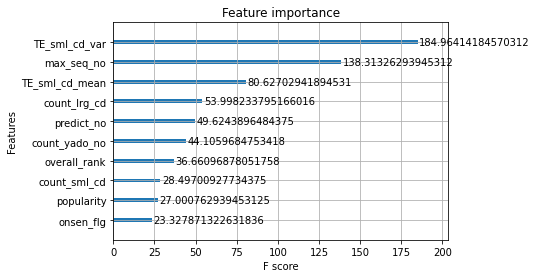

In [15]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# 以下はモデルの訓練コードと同様
# ...

# 特徴量重要度の取得
feature_importances = model.get_score(importance_type='gain')

# 特徴量名とその重要度を DataFrame に変換
feature_importances_df = pd.DataFrame(feature_importances.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# 重要度が高い上位の特徴量を表示
print(feature_importances_df.head())

# 特徴量重要度のグラフ表示
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='gain', max_num_features=10)
plt.show()

In [16]:
# train_dfのyado_noをyad_noに変更
train_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [17]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yad_no', 'oof_pred']].head()

session_id  yad_no  oof_pred
0  000125c737df1802b6e365f93c96d3c8    7531  0.426184
1  000125c737df1802b6e365f93c96d3c8     441  0.211613
2  000125c737df1802b6e365f93c96d3c8    2480  0.743949
3  000125c737df1802b6e365f93c96d3c8   13240  0.562912
4  000125c737df1802b6e365f93c96d3c8   10378  0.420119

In [18]:
train_df[['session_id', 'yad_no', 'oof_pred']]

session_id  yad_no   oof_pred
0        000125c737df1802b6e365f93c96d3c8    7531   0.426184
1        000125c737df1802b6e365f93c96d3c8     441   0.211613
2        000125c737df1802b6e365f93c96d3c8    2480   0.743949
3        000125c737df1802b6e365f93c96d3c8   13240   0.562912
4        000125c737df1802b6e365f93c96d3c8   10378   0.420119
...                                   ...     ...        ...
2777522  fffe8a472ae6a96c9da05a30ac3ed6c5    4772  -9.072260
2777523  fffe8a472ae6a96c9da05a30ac3ed6c5    1482  -7.516726
2777524  fffe8a472ae6a96c9da05a30ac3ed6c5    4116  -5.989255
2777525  fffe8a472ae6a96c9da05a30ac3ed6c5   10613 -10.397121
2777526  fffe8a472ae6a96c9da05a30ac3ed6c5    4526  -7.889231

[2777527 rows x 3 columns]

In [19]:
oof_pred_df = train_df[['session_id', 'yad_no', 'oof_pred']]
oof_pred_df

session_id  yad_no   oof_pred
0        000125c737df1802b6e365f93c96d3c8    7531   0.426184
1        000125c737df1802b6e365f93c96d3c8     441   0.211613
2        000125c737df1802b6e365f93c96d3c8    2480   0.743949
3        000125c737df1802b6e365f93c96d3c8   13240   0.562912
4        000125c737df1802b6e365f93c96d3c8   10378   0.420119
...                                   ...     ...        ...
2777522  fffe8a472ae6a96c9da05a30ac3ed6c5    4772  -9.072260
2777523  fffe8a472ae6a96c9da05a30ac3ed6c5    1482  -7.516726
2777524  fffe8a472ae6a96c9da05a30ac3ed6c5    4116  -5.989255
2777525  fffe8a472ae6a96c9da05a30ac3ed6c5   10613 -10.397121
2777526  fffe8a472ae6a96c9da05a30ac3ed6c5    4526  -7.889231

[2777527 rows x 3 columns]

In [20]:
# アンサンブル用にoof_predを保存
oof_pred_df.to_csv('../ensemble/xgbRanker_ver5_oof_pred.csv', index=False)

In [21]:
oof_pred_df

session_id  yad_no   oof_pred
0        000125c737df1802b6e365f93c96d3c8    7531   0.426184
1        000125c737df1802b6e365f93c96d3c8     441   0.211613
2        000125c737df1802b6e365f93c96d3c8    2480   0.743949
3        000125c737df1802b6e365f93c96d3c8   13240   0.562912
4        000125c737df1802b6e365f93c96d3c8   10378   0.420119
...                                   ...     ...        ...
2777522  fffe8a472ae6a96c9da05a30ac3ed6c5    4772  -9.072260
2777523  fffe8a472ae6a96c9da05a30ac3ed6c5    1482  -7.516726
2777524  fffe8a472ae6a96c9da05a30ac3ed6c5    4116  -5.989255
2777525  fffe8a472ae6a96c9da05a30ac3ed6c5   10613 -10.397121
2777526  fffe8a472ae6a96c9da05a30ac3ed6c5    4526  -7.889231

[2777527 rows x 3 columns]

### CVの計算

In [22]:
train_log_df = pd.read_csv('../train_log.csv')
train_label_df = pd.read_csv('../train_label.csv')

In [23]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
oof_pred_df = oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
oof_pred_df.set_index('session_id', inplace=True)

In [24]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = '000104bdffaaad1a1e0a9ebacf585f33'
recommendations = get_top_recommendations(session_id_to_check, oof_pred_df)
print(recommendations)

[3894, 7749, 902, 11380, 1284, 5490, 254, 4072, 12491]
CPU times: user 156 ms, sys: 7 µs, total: 156 ms
Wall time: 156 ms


In [25]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = train_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = train_label_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(train_label_df))}
    for future in tqdm(as_completed(future_to_session), total=len(train_label_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 288698/288698 [00:43<00:00, 6673.36it/s]


In [26]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
result_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
result_df.columns = [f'predict_{i}' for i in range(result_df.shape[1])]
# 最初の列にセッションIDを追加する
# result_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
result_df

predict_0  predict_1  predict_2  predict_3  predict_4  predict_5  \
0            2808       5289        997       4101      11882      12846   
1            1586       2570      11104       3564       2259       4488   
2            4863       9039       6722       1967      13642       7509   
3             626      13549        109        755      11715       7812   
4              96       3894       7749        902      11380       1284   
...           ...        ...        ...        ...        ...        ...   
288693       5719       1586      13717       3725      13079      10955   
288694        513       4767       2900        399       8465       3940   
288695       3566       7820       2087       4398       4040       7308   
288696      10619      11091      12500        570       7551       3238   
288697       2439      10095          3       1372      12154       6579   

        predict_6  predict_7  predict_8  predict_9  
0            3324       9208       9209       9207  
1            3725       8747       8253       8225  
2            5238       2957      11724       4355  
3            1341      13296       7872       2272  
4            5490        254       4072      12491  
...           ...        ...        ...        ...  
288693      10522       2876       8677      13210  
288694       6654       5299        963       8703  
288695        844       9558      12240      10364  
288696      12781      10616      12829      11316  
288697      10415      10439       9624       5294  

[288698 rows x 10 columns]

### 要素の集合にバグがないかを確認

In [27]:
candidate_ver15_train = pd.read_csv('../data/candidate_ver15_train.csv')

In [28]:
# 既存のDataFrameを読み込む
df1 = candidate_ver15_train
df2 = result_df#.drop(columns=['has_duplicates'])
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


### 順位変動のあったカラムの数を確認する

In [29]:
candidate_ver15_train

predict_0  predict_1  predict_2  predict_3  predict_4  predict_5  \
0           11882       2808       5289       4101       3324      12846   
1            8253       8747       2570       1586      11104       3725   
2            9039       6722       7509       4355       4863      11724   
3             626        755      11715       7812        109       2272   
4              96       3894       7749        902      11380       5490   
...           ...        ...        ...        ...        ...        ...   
288693      13210      13079       2876       3725       8677      13717   
288694       8703       3940        399       4767       2900       6654   
288695       7308      12240       4040       7820       4398       2087   
288696      10619        570      12500      11091       7551       3238   
288697       2439      10095       1372      12154          3      10439   

        predict_6  predict_7  predict_8  predict_9  
0             997       9207       9209       9208  
1            4488       2259       3564       8225  
2            5238      13642       1967       2957  
3           13296       1341      13549       7872  
4            1284      12491        254       4072  
...           ...        ...        ...        ...  
288693       1586      10955      10522       5719  
288694       5299       8465        963        513  
288695       9558       3566        844      10364  
288696      10616      12781      12829      11316  
288697       9624      10415       6579       5294  

[288698 rows x 10 columns]

In [30]:
# 各要素が一致しているかどうかをチェック
diff = candidate_ver15_train != result_df

# 一致していない行のインデックスを抽出
mismatched_indices = diff.any(axis=1)
mismatched_rows = candidate_ver15_train[mismatched_indices]

print("一致していない行のインデックス：")
print(mismatched_indices)
print("一致していない行：")
print(len(mismatched_rows))

一致していない行のインデックス：
0         True
1         True
2         True
3         True
4         True
          ... 
288693    True
288694    True
288695    True
288696    True
288697    True
Length: 288698, dtype: bool
一致していない行：
287914


In [31]:
candidate_ver15_train[mismatched_indices].head(20)

predict_0  predict_1  predict_2  predict_3  predict_4  predict_5  \
0       11882       2808       5289       4101       3324      12846   
1        8253       8747       2570       1586      11104       3725   
2        9039       6722       7509       4355       4863      11724   
3         626        755      11715       7812        109       2272   
4          96       3894       7749        902      11380       5490   
5       10510       4823      12544       5369          1       9207   
6        7531        441       2480      13240      10378       2282   
7        4744       9508       7681      10362      12962       1755   
8       13220      12432        899       4014       3802       1227   
9       10478        379        550       3278       3483       6592   
10       1209      12271       5871       9029        966      10293   
11        756      10375       3998      11302       2800       1531   
12       1818       4646      11283      13770       3215         79   
13       7093      12178       5948      12646      10095       8553   
14        143      12862       4066       6555      11984       7014   
15       2626       2707       4352       8444       7041       4315   
16        569       9979       2145       9338       9020       5650   
17      11123       7888       8771       1997       1885       5744   
18       6757      12147       9662       4656       5161      12053   
19      13092       5154      12962       5259       4065      10515   

    predict_6  predict_7  predict_8  predict_9  
0         997       9207       9209       9208  
1        4488       2259       3564       8225  
2        5238      13642       1967       2957  
3       13296       1341      13549       7872  
4        1284      12491        254       4072  
5        9199       9200       9201       9202  
6        7273      10442      12774       4574  
7       12125      12464        111      10544  
8        3644       2164      13702       9723  
9        9773       9430       4303       2806  
10      10750       5631       3783       8439  
11       9210       9200       9201       9202  
12       9110        693       9450      13017  
13      12350       1779      10211       3848  
14      10644       5055      13249       5267  
15       1744       7848       1690       2220  
16        924       2355       2893       3187  
17      12942        831       2278      10997  
18       7394       5058      10993       1549  
19      13776       7283       5566       3521

In [28]:
result_df[mismatched_indices].head(20)

predict_0  predict_1  predict_2  predict_3  predict_4  predict_5  \
0        4101       2808      11882        997      12846       5289   
1        8253       2259      11104       8747       3564       4488   
2        4355       9039       6722       4863       5238       7509   
3         626       1341       7872      13549       7812        109   
4          96       3894       7749        902      11380       5490   
5        4823      10510      12544       5369       9199       9207   
6        4574       7531       2480       2282      10378       7273   
7        7681      12962       9508      10362      12125       4744   
8        1227        899       3644      12432       9723       4014   
9        3278       6592       9773       3483        379        550   
10      12271      10750       5871       1209       9029       5631   
11        756      10375       3998       9210      11302       2800   
12      13017      13770       1818      11283        693       3215   
13      10095      12350       8553      10211      12178      12646   
14        143      12862       6555       4066       7014      11984   
15       2626       4315       7848       2707       1744       4352   
16        569       9338       9979       2145       2893       9020   
17      10997       7888        831       8771       5744       1885   
18      12147       9662       6757       7394      10993       5161   
19      13092      12962       3521       5259      10515      13776   

    predict_6  predict_7  predict_8  predict_9  
0        3324       9208       9207       9209  
1        1586       2570       3725       8225  
2        1967       2957      13642      11724  
3        2272        755      11715      13296  
4        1284        254       4072      12491  
5        9202       9201       9200          1  
6       13240      10442        441      12774  
7       12464       1755        111      10544  
8        3802      13220       2164      13702  
9        4303      10478       2806       9430  
10       8439        966       3783      10293  
11       1531       9200       9202       9201  
12       4646       9450       9110         79  
13       7093       5948       3848       1779  
14       5055      10644       5267      13249  
15       2220       8444       1690       7041  
16       5650       2355       3187        924  
17      12942       1997       2278      11123  
18       5058      12053       1549       4656  
19       5566       5154       7283       4065

In [32]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.values

In [33]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

In [34]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.45633756953908117


In [35]:
# 各行内で重複があるかどうかをチェック
def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
result_df['has_duplicates'] = result_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = result_df[result_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [36]:
# 欠損がないかをチェック
result_df.isnull().sum(axis=1).sum()

0

In [37]:
result_df.head()

predict_0  predict_1  predict_2  predict_3  predict_4  predict_5  \
0       2808       5289        997       4101      11882      12846   
1       1586       2570      11104       3564       2259       4488   
2       4863       9039       6722       1967      13642       7509   
3        626      13549        109        755      11715       7812   
4         96       3894       7749        902      11380       1284   

   predict_6  predict_7  predict_8  predict_9  has_duplicates  
0       3324       9208       9209       9207           False  
1       3725       8747       8253       8225           False  
2       5238       2957      11724       4355           False  
3       1341      13296       7872       2272           False  
4       5490        254       4072      12491           False

### 推論用の候補テーブル作成

In [47]:
test_log_df = pd.read_csv('../test_log.csv')
test_session_df = pd.read_csv('../test_session.csv')

In [48]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[ 0.67667085 -0.5355472   0.27822858 ...  0.2938148   0.44814047
  0.39276648]
1683604


In [49]:
# test_predの形を調べる
print(np.array(test_pred).shape)

(10, 1683604)


In [50]:
# test_dfのyado_noをyad_noに変更
test_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [51]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yad_no', 'target']].head()

session_id  yad_no    target
0  00001149e9c73985425197104712478c   11561  0.676671
1  00001149e9c73985425197104712478c    4714 -0.535547
2  00001149e9c73985425197104712478c    2680  0.278229
3  00001149e9c73985425197104712478c    4420 -1.437948
4  00001149e9c73985425197104712478c    5466 -0.448302

In [52]:
test_oof_pred_df = test_df[['session_id', 'yad_no', 'target']]
test_oof_pred_df

session_id  yad_no    target
0        00001149e9c73985425197104712478c   11561  0.676671
1        00001149e9c73985425197104712478c    4714 -0.535547
2        00001149e9c73985425197104712478c    2680  0.278229
3        00001149e9c73985425197104712478c    4420 -1.437948
4        00001149e9c73985425197104712478c    5466 -0.448302
...                                   ...     ...       ...
1683599  ffffe984aafd6127ce8e43e3ca40c79d    5623  0.488023
1683600  ffffe984aafd6127ce8e43e3ca40c79d    3781  0.450520
1683601  ffffe984aafd6127ce8e43e3ca40c79d   11994  0.293815
1683602  ffffe984aafd6127ce8e43e3ca40c79d     634  0.448140
1683603  ffffe984aafd6127ce8e43e3ca40c79d   12620  0.392766

[1683604 rows x 3 columns]

In [53]:
# test_oof_pred_dfのカラム名を変更
test_oof_pred_df.rename(columns={'target': 'oof_pred'}, inplace=True)
test_oof_pred_df

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


session_id  yad_no  oof_pred
0        00001149e9c73985425197104712478c   11561  0.676671
1        00001149e9c73985425197104712478c    4714 -0.535547
2        00001149e9c73985425197104712478c    2680  0.278229
3        00001149e9c73985425197104712478c    4420 -1.437948
4        00001149e9c73985425197104712478c    5466 -0.448302
...                                   ...     ...       ...
1683599  ffffe984aafd6127ce8e43e3ca40c79d    5623  0.488023
1683600  ffffe984aafd6127ce8e43e3ca40c79d    3781  0.450520
1683601  ffffe984aafd6127ce8e43e3ca40c79d   11994  0.293815
1683602  ffffe984aafd6127ce8e43e3ca40c79d     634  0.448140
1683603  ffffe984aafd6127ce8e43e3ca40c79d   12620  0.392766

[1683604 rows x 3 columns]

In [54]:
test_oof_pred_df

session_id  yad_no  oof_pred
0        00001149e9c73985425197104712478c   11561  0.676671
1        00001149e9c73985425197104712478c    4714 -0.535547
2        00001149e9c73985425197104712478c    2680  0.278229
3        00001149e9c73985425197104712478c    4420 -1.437948
4        00001149e9c73985425197104712478c    5466 -0.448302
...                                   ...     ...       ...
1683599  ffffe984aafd6127ce8e43e3ca40c79d    5623  0.488023
1683600  ffffe984aafd6127ce8e43e3ca40c79d    3781  0.450520
1683601  ffffe984aafd6127ce8e43e3ca40c79d   11994  0.293815
1683602  ffffe984aafd6127ce8e43e3ca40c79d     634  0.448140
1683603  ffffe984aafd6127ce8e43e3ca40c79d   12620  0.392766

[1683604 rows x 3 columns]

In [55]:
# アンサンブル用にoof_predを保存
test_oof_pred_df.to_csv('../ensemble/xgbRanker_ver5_test_pred.csv', index=False)

In [56]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
test_oof_pred_df = test_oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
test_oof_pred_df.set_index('session_id', inplace=True)

In [57]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = 'ffffe984aafd6127ce8e43e3ca40c79d'
recommendations = get_top_recommendations(session_id_to_check, test_oof_pred_df)
print(recommendations)

[10729, 12767, 867, 5623, 3781, 634, 12620, 11723, 11994, 1891]
CPU times: user 92.1 ms, sys: 3.97 ms, total: 96 ms
Wall time: 95.8 ms


In [58]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = test_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = test_session_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=test_oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(test_session_df))}
    for future in tqdm(as_completed(future_to_session), total=len(test_session_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 174700/174700 [00:25<00:00, 6878.52it/s]


In [59]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
test_expanded_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
test_expanded_df.columns = [f'predict_{i}' for i in range(test_expanded_df.shape[1])]
# 最初の列にセッションIDを追加する
# expanded_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
test_expanded_df

predict_0  predict_1  predict_2  predict_3  predict_4  predict_5  \
0            3560      11561       2680       5466       4714       4420   
1            7014      12862      11237       8108       6555       4066   
2             757       9190       9910       7710       6721        410   
3           12341       3359       6991      13521      10861       1542   
4           10826       6161       3476       3844       9623       2862   
...           ...        ...        ...        ...        ...        ...   
174695       1997       7888       5744      11123       7062       2278   
174696      12432       1227       4014       3802       3644      13220   
174697       2087       7308      11796      13241       8143      13719   
174698       2692       5513       2373      12281       3002       3100   
174699      10729      12767        867       5623       3781        634   

        predict_6  predict_7  predict_8  predict_9  
0            9830       9534       5785       6563  
1           11923        143       6129        613  
2            1774      10485       6730      13570  
3            4180       5080      10746       6489  
4            5372       9020       3854      12029  
...           ...        ...        ...        ...  
174695      10997      10042       3440       9743  
174696        899       9723       2164      13702  
174697      13797      12939       5810      11037  
174698      10287       1687      13672       4976  
174699      12620      11723      11994       1891  

[174700 rows x 10 columns]

In [60]:
# 各行内で重複があるかどうかをチェック

def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
test_expanded_df['has_duplicates'] = test_expanded_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = test_expanded_df[test_expanded_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [61]:
# 欠損がないかをチェック
test_expanded_df.isnull().sum(axis=1).sum()

0

In [62]:
candidate_ver15_test = pd.read_csv('../data/candidate_ver15_test.csv')
candidate_ver15_test

predict_0  predict_1  predict_2  predict_3  predict_4  predict_5  \
0            3560      11561       4714       2680       4420       5466   
1             143       4066       6555       7014      11923       8108   
2             757       9190       7710       1774       9910      10485   
3           12341       3359       6991       1542      13521       5080   
4            9020       2862      10826      12029       3854       3476   
...           ...        ...        ...        ...        ...        ...   
174695       1997       7888       5744      11123      10997       7062   
174696      13220      12432        899       4014       3802       1227   
174697      13241      13797      13719      12939       7308       2087   
174698       3100      10287       3002       2373      12281       4976   
174699      12767      10729       1891      11723        867       5623   

        predict_6  predict_7  predict_8  predict_9  
0            9830       9534       6563       5785  
1            6129        613      11237      12862  
2            6721        410      13570       6730  
3           10861       4180      10746       6489  
4            9623       3844       5372       6161  
...           ...        ...        ...        ...  
174695       9743       2278      10042       3440  
174696       3644       2164      13702       9723  
174697       8143      11796      11037       5810  
174698      13672       2692       5513       1687  
174699       3781      11994        634      12620  

[174700 rows x 10 columns]

In [63]:
# 行ごとに要素の集合が異なっていないかをチェック
import pandas as pd

# 既存のDataFrameを読み込む
df1 = candidate_ver15_test
df2 = test_expanded_df.drop('has_duplicates', axis=1)
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


In [64]:
candidate_ver15_test

predict_0  predict_1  predict_2  predict_3  predict_4  predict_5  \
0            3560      11561       4714       2680       4420       5466   
1             143       4066       6555       7014      11923       8108   
2             757       9190       7710       1774       9910      10485   
3           12341       3359       6991       1542      13521       5080   
4            9020       2862      10826      12029       3854       3476   
...           ...        ...        ...        ...        ...        ...   
174695       1997       7888       5744      11123      10997       7062   
174696      13220      12432        899       4014       3802       1227   
174697      13241      13797      13719      12939       7308       2087   
174698       3100      10287       3002       2373      12281       4976   
174699      12767      10729       1891      11723        867       5623   

        predict_6  predict_7  predict_8  predict_9  
0            9830       9534       6563       5785  
1            6129        613      11237      12862  
2            6721        410      13570       6730  
3           10861       4180      10746       6489  
4            9623       3844       5372       6161  
...           ...        ...        ...        ...  
174695       9743       2278      10042       3440  
174696       3644       2164      13702       9723  
174697       8143      11796      11037       5810  
174698      13672       2692       5513       1687  
174699       3781      11994        634      12620  

[174700 rows x 10 columns]

In [65]:
test_expanded_df

predict_0  predict_1  predict_2  predict_3  predict_4  predict_5  \
0            3560      11561       2680       5466       4714       4420   
1            7014      12862      11237       8108       6555       4066   
2             757       9190       9910       7710       6721        410   
3           12341       3359       6991      13521      10861       1542   
4           10826       6161       3476       3844       9623       2862   
...           ...        ...        ...        ...        ...        ...   
174695       1997       7888       5744      11123       7062       2278   
174696      12432       1227       4014       3802       3644      13220   
174697       2087       7308      11796      13241       8143      13719   
174698       2692       5513       2373      12281       3002       3100   
174699      10729      12767        867       5623       3781        634   

        predict_6  predict_7  predict_8  predict_9  has_duplicates  
0            9830       9534       5785       6563           False  
1           11923        143       6129        613           False  
2            1774      10485       6730      13570           False  
3            4180       5080      10746       6489           False  
4            5372       9020       3854      12029           False  
...           ...        ...        ...        ...             ...  
174695      10997      10042       3440       9743           False  
174696        899       9723       2164      13702           False  
174697      13797      12939       5810      11037           False  
174698      10287       1687      13672       4976           False  
174699      12620      11723      11994       1891           False  

[174700 rows x 11 columns]

In [66]:
test_expanded_df.drop(columns=['has_duplicates']).to_csv('../submissions/xgbRanker_ver5.csv', index=False)